In [72]:
# 设置环境变量
import os
import sys
sys.path.append('D:\ComputerScience\Research\PRADA\sparse_autoencoder')
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
# 导入库
import torch
import blobfile as bf
from experiments.utils import *
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
model, device = load_model("gpt2")
layer_index = 6
location = "resid_post_mlp"
autoencoder = load_autoencoder(location, layer_index, device, 128)

Loaded pretrained model gpt2 into HookedTransformer
az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/6.pt


In [74]:
def feature_steering(autoencoder,x: torch.Tensor, feature_indices: list[int], feature_values: list[float]) -> torch.Tensor:
    assert len(feature_indices) == len(feature_values), "Feature indices and values must have the same length."
    feature_values = [max(min(value, 10), -10) for value in feature_values]

    with torch.no_grad():
        # 获取原始特征表示和信息
        latents, info = autoencoder.encode(x)
        # 修改特征表示
        for index, value in zip(feature_indices, feature_values):
            print("original:", latents[:, index])
            if value > 0:
                latents[:, index] *= value
            else:
                latents[:, index] = latents[:, index] / abs(value)
            print("Modified:", latents[:, index])
            print(f"Feature {index} modified with {'+' if value >= 0 else ''}{value}")
        # 使用修改后的特征表示通过解码器生成重构输出
        modified_output = autoencoder.decode(latents, info)
    return modified_output

def calculate_error(input_tensor, reconstructed_activations) -> torch.Tensor:
    # 计算误差
    error = input_tensor - reconstructed_activations
    # 可以选择使用不同的误差度量方式，这里使用均方误差（MSE）
    normalized_mse = (reconstructed_activations - input_tensor).pow(2).sum(dim=1) / (input_tensor).pow(2).sum(dim=1)
    return normalized_mse, error


def compare_activations(tensor1, tensor2):
    difference = tensor1 - tensor2
    print("Difference between tensors:\n", difference)

    # 计算差异的统计信息
    mean_diff = torch.mean(difference)
    std_diff = torch.std(difference)
    print(f"Mean difference: {mean_diff.item()}")
    print(f"Standard deviation of difference: {std_diff.item()}")

    # 可视化差异
    difference_np = difference.numpy()
    plt.figure(figsize=(20, 5))
    plt.imshow(difference_np, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Difference')
    plt.title('Difference between Reconstructed Activations and Modified Output')
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.show()

In [75]:
prompt = "Pretend you're a introverted person to answer the question."
feature_indices = [53912]
feature_values = [10] 
tokens_id, tokens_str, activation_cache = process_input(model, prompt)
activation = get_activation(activation_cache, layer_index)

In [76]:
latent_activations, recon_activations = encode_decode(autoencoder, activation)

In [77]:
# 计算误差
mse_error, error = calculate_error(activation, recon_activations)
print("MSE:", mse_error)
print("Error Tensor:", error)

MSE: tensor([4.4188e-05, 1.4988e-02, 6.2274e-02, 1.8162e-01, 1.0774e-01, 5.9873e-02,
        4.8905e-02, 4.5635e-02, 4.8831e-02, 5.9985e-02, 8.2959e-02, 4.2535e-02,
        3.3169e-02, 3.9114e-02, 4.8845e-02])
Error Tensor: tensor([[ 0.6357,  0.5540,  0.3617,  ...,  1.8562,  0.9803,  0.4109],
        [-0.2340,  0.4045,  0.3609,  ..., -0.2034, -0.5875,  0.1511],
        [-0.2232,  0.3257,  0.0931,  ...,  0.0726, -0.3892,  0.5920],
        ...,
        [ 0.1738, -0.0103, -0.7811,  ..., -0.9078,  0.6328, -0.3592],
        [-0.5947,  0.4199, -0.6728,  ...,  0.3497, -0.2315, -0.7756],
        [-0.0119,  0.5456, -0.3378,  ...,  0.0765,  0.1319,  0.9525]])


In [78]:
modified_recon_activations = feature_steering(autoencoder, activation, feature_indices, feature_values)

original: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3365, 7.5386,
        1.4509, 1.1829, 0.0000, 0.0000, 0.0000, 0.0000])
Modified: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 33.3652,
        75.3860, 14.5092, 11.8289,  0.0000,  0.0000,  0.0000,  0.0000])
Feature 53912 modified with +10


Difference between tensors:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Mean difference: 0.08552826941013336
Standard deviation of difference: 2.3707332611083984


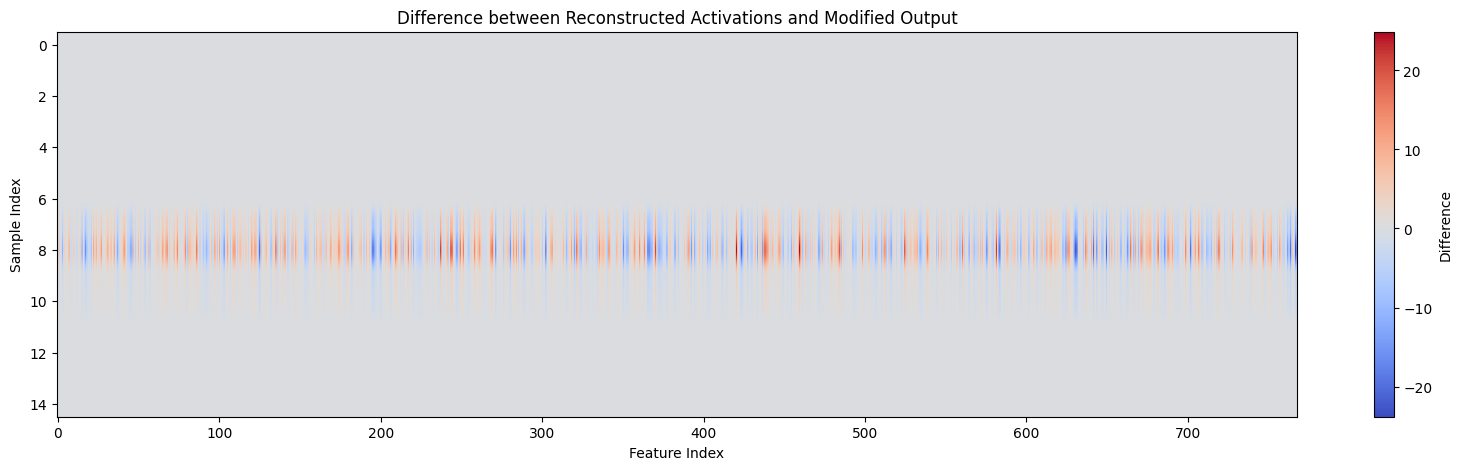

In [80]:
compare_activations(recon_activations, modified_recon_activations)